## Neural Network for Binary Classification

In [3]:
"""A multi-layer perceptron for binary classification of MNIST handwritten digits."""
from __future__ import absolute_import, division
from __future__ import print_function
from builtins import range
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import grad
from autograd.misc.flatten import flatten
from data import load_mnist
import matplotlib.pyplot as plt
import scipy.linalg as la

"""Neural net functions. Simple fully connected neural network with sigmoid binary cross-entropy loss"""

def init_random_params(scale, layer_sizes, rs=npr.RandomState(0)):
    """Build a list of (weights, biases) tuples,
       one for each layer in the net."""
    return [(scale * rs.randn(m, n),   # weight matrix
             scale * rs.randn(n))      # bias vector
            for m, n in zip(layer_sizes[:-1], layer_sizes[1:])]

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def neural_net_predict(params, inputs):
    """Implements a deep neural network for classification.
       params is a list of (weights, bias) tuples.
       inputs is an (N x D) matrix.
       returns normalized class log-probabilities."""
    for W, b in params:
        outputs = np.dot(inputs, W) + b
        inputs = np.tanh(outputs)
    return sigmoid(outputs)

def cross_entropy(params, inputs, targets):
    m = inputs.shape[0]
    predict = neural_net_predict(params, inputs)
    return (1/m)*np.sum(-targets*np.log(predict)-(1-targets)*np.log(1-predict))

def accuracy(params, inputs, targets):
    predict_probability = neural_net_predict(params, inputs)
    predict = predict_probability > 0.5
    return np.mean(predict == targets)

def batch_indices(iter):
    idx = iter % num_batches
    return slice(idx * batch_size, (idx+1) * batch_size)

# Define training objective
def objective(params, iter, train_labels):
    idx = batch_indices(iter)
    return cross_entropy(params, train_images[idx], train_labels[idx])

def record_accuracy(params, iter, train_labels, test_labels):
    train_acc  = accuracy(params, train_images, train_labels)
    test_acc  = accuracy(params, test_images, test_labels)
    return train_acc, test_acc 

    
"""Some standard gradient-based stochastic optimizers."""

'''
def sgd(grad, x, callback=None, num_iters=200, step_size=0.1, mass=0.9):
    """Stochastic gradient descent with momentum.
    grad() must have signature grad(x, i), where i is the iteration number."""
    velocity = np.zeros(len(x))
    for i in range(num_iters):
        g = grad(x, i)
        if callback: callback(x, i, g)
        velocity = mass * velocity - (1.0 - mass) * g
        x = x + step_size * velocity
    return x

@unflatten_optimizer
def rmsprop(grad, x, callback=None, num_iters=100,
            step_size=0.1, gamma=0.9, eps=10**-8):
    """Root mean squared prop: See Adagrad paper for details."""
    avg_sq_grad = np.ones(len(x))
    for i in range(num_iters):
        g = grad(x, i)
        if callback: callback(x, i, g)
        avg_sq_grad = avg_sq_grad * gamma + g**2 * (1 - gamma)
        x = x - step_size * g/(np.sqrt(avg_sq_grad) + eps)
    return x
'''

def adam(grad, x, train_lab, test_lab, callback=None, num_iters=100,
         step_size=0.001, b1=0.9, b2=0.999, eps=10**-8):
    """Adam as described in http://arxiv.org/pdf/1412.6980.pdf.
    It's basically RMSprop with momentum and some correction terms."""
    
    x_flat,unflatten = flatten(x)
    m = np.zeros(len(x_flat))
    v = np.zeros(len(x_flat))
    
    train_perf = [0]
    test_perf = [0]
    
    for i in range(num_iters):
        
        if test_perf[-1] > 0.98:
            break
        
        g = flatten(grad(x, i, train_lab))[0]
        x_flat = flatten(x)[0]
        
        if callback: 
            train_acc, test_acc = callback(x, i, train_lab, test_lab)
            train_perf.append(train_acc)
            test_perf.append(test_acc)
            
        m = (1 - b1) * g      + b1 * m  # First  moment estimate.
        v = (1 - b2) * (g**2) + b2 * v  # Second moment estimate.
        mhat = m / (1 - b1**(i + 1))    # Bias correction.
        vhat = v / (1 - b2**(i + 1))
        x = unflatten(x_flat - step_size*mhat/(np.sqrt(vhat) + eps))
    return x, i, train_perf, test_perf

# Load training data and set experiment parameters

In [4]:
N, train_images, train_labels_orig, test_images, test_labels_orig = load_mnist()
print("done loading training data")

# Model parameters
layer_sizes = [784, 10, 5, 1]

# Training parameters
param_scale = 0.1
batch_size = 256
num_epochs = 10
step_size = 0.001
num_batches = int(np.ceil(len(train_images) / batch_size))
max_iter = num_epochs * num_batches

print('batch size per iteration is', batch_size)
print('number of batches per epoch is', num_batches)
print('number of epochs is', num_epochs)
print('max iterations per goal is', max_iter)

# set goals
goal1 = 4
goal2 = 5

# Get gradient of objective using autograd.
objective_grad = grad(objective)


done loading training data
batch size per iteration is 256
number of batches per epoch is 235
number of epochs is 10
max iterations per goal is 2350


## Oscillation experiments

In [3]:
def no_osc_goal(train_labels_orig, test_labels_orig, goal1, goal2, init_params, obj_grad, step_size, max_it):

    train_n = int(train_labels_orig.shape[0])
    test_n = int(test_labels_orig.shape[0])

    ### goal 1 ###
    train_labels = train_labels_orig[:,goal1].reshape((train_n,1))
    test_labels = test_labels_orig[:,goal1].reshape((test_n,1))

    print('')
    print('no oscillation experiment begin')
    print('training goal 1')
    opt_params_g1, iter_g1, tr_perf_g1, tst_perf_g1 = adam(obj_grad, init_params, train_labels, test_labels,
                            step_size=step_size,num_iters=max_it, callback=record_accuracy)
    
    print('goal 1 converged')
    print('training accuracy for goal 2 optimal =', tst_perf_g1[-1])
    
    ### goal 2 ###
    train_labels = train_labels_orig[:,goal2].reshape((train_n,1))
    test_labels = test_labels_orig[:,goal2].reshape((test_n,1))

    print('training goal 2')
    opt_params_g2, iter_g2, tr_perf_g2, tst_perf_g2 = adam(obj_grad, init_params, train_labels, test_labels,
                            step_size=step_size,num_iters=max_it, callback=record_accuracy)
    print('goal 2 converged')
    print('training accuracy for goal 2 optimal =', tst_perf_g2[-1])
    
    l2_diff = la.norm(flatten(opt_params_g1)[0]-flatten(opt_params_g2)[0],2)
    
    return l2_diff,iter_g1,iter_g2

def osc_goal(train_labels_orig, test_labels_orig, goal1, goal2, init_params, obj_grad, step_size, max_it, num_cycles):

    train_n = int(train_labels_orig.shape[0])
    test_n = int(test_labels_orig.shape[0])

    train_labels_g1 = train_labels_orig[:,goal1].reshape((train_n,1))
    test_labels_g1 = test_labels_orig[:,goal1].reshape((test_n,1))
    
    train_labels_g2 = train_labels_orig[:,goal2].reshape((train_n,1))
    test_labels_g2 = test_labels_orig[:,goal2].reshape((test_n,1))
    
    print('')
    print('oscillating goals experiment begin')
    print('initial optimization')
    print('training goal 1')
    opt_params_g1, iter_g1, _, tst_perf_g1 = adam(obj_grad, init_params, train_labels_g1, test_labels_g1,
                            step_size=step_size,num_iters=max_it, callback=record_accuracy)
    
    print('goal 1 converged')
    print('training accuracy for goal 2 optimal =', tst_perf_g1[-1])
    
    cycle_counter = 0
    
    l2_list = []
    iter_g1g2 = []
    iter_g2g1 = []
    
    while cycle_counter < num_cycles:

        print('')
        print('cycle', cycle_counter+1)

        print('training goal 2')
        opt_params_g2, iter_g2, _, tst_perf_g2 = adam(obj_grad, opt_params_g1, train_labels_g2, test_labels_g2,
                                step_size=step_size,num_iters=max_it, callback=record_accuracy)
        print('goal 2 converged')
        print('training accuracy for goal 2 optimal =', tst_perf_g2[-1])

        
        print('training goal 1')
        opt_params_g1, iter_g1, _, tst_perf_g1 = adam(obj_grad, opt_params_g2, train_labels_g1, test_labels_g1,
                                step_size=step_size,num_iters=max_it, callback=record_accuracy)

        print('goal 1 converged')
        print('training accuracy for goal 2 optimal =', tst_perf_g1[-1])
        
        iter_g1g2.append(iter_g2)
        iter_g2g1.append(iter_g1)
        l2_list.append(la.norm(flatten(opt_params_g1)[0]-flatten(opt_params_g2)[0],2))

        cycle_counter += 1
        
    return l2_list,iter_g1g2,iter_g2g1

In [9]:

init_params = init_random_params(param_scale, layer_sizes)

import time
start = time.time()
l2_no_osc, g1_iter, g2_iter = no_osc_goal(train_labels_orig, test_labels_orig, 
                                 goal1, goal2, init_params, objective_grad, step_size, max_iter)
end = time.time()
print(end - start)


no oscillation experiment begin
training goal 1
goal 1 converged
training accuracy for goal 2 optimal = 0.9804
training goal 2
goal 2 converged
training accuracy for goal 2 optimal = 0.9801
76.28918790817261


In [10]:
num_cycles = 100


import time
start = time.time()

l2_osc, g1g2_iter, g2g1_iter = osc_goal(train_labels_orig, test_labels_orig, 
                                        goal1, goal2, init_params, objective_grad, step_size, max_iter, num_cycles)
end = time.time()
print(end - start)


oscillating goals experiment begin
initial optimization
training goal 1
goal 1 converged
training accuracy for goal 2 optimal = 0.9804

cycle 1
training goal 2
goal 2 converged
training accuracy for goal 2 optimal = 0.9803
training goal 1
goal 1 converged
training accuracy for goal 2 optimal = 0.9804

cycle 2
training goal 2
goal 2 converged
training accuracy for goal 2 optimal = 0.9802
training goal 1
goal 1 converged
training accuracy for goal 2 optimal = 0.9806

cycle 3
training goal 2
goal 2 converged
training accuracy for goal 2 optimal = 0.9801
training goal 1
goal 1 converged
training accuracy for goal 2 optimal = 0.9801

cycle 4
training goal 2
goal 2 converged
training accuracy for goal 2 optimal = 0.9801
training goal 1
goal 1 converged
training accuracy for goal 2 optimal = 0.9801

cycle 5
training goal 2
goal 2 converged
training accuracy for goal 2 optimal = 0.9801
training goal 1
goal 1 converged
training accuracy for goal 2 optimal = 0.9801

cycle 6
training goal 2
goal

goal 2 converged
training accuracy for goal 2 optimal = 0.9804
training goal 1
goal 1 converged
training accuracy for goal 2 optimal = 0.9804

cycle 50
training goal 2
goal 2 converged
training accuracy for goal 2 optimal = 0.9802
training goal 1
goal 1 converged
training accuracy for goal 2 optimal = 0.9807

cycle 51
training goal 2
goal 2 converged
training accuracy for goal 2 optimal = 0.9803
training goal 1
goal 1 converged
training accuracy for goal 2 optimal = 0.9811

cycle 52
training goal 2
goal 2 converged
training accuracy for goal 2 optimal = 0.9801
training goal 1
goal 1 converged
training accuracy for goal 2 optimal = 0.9808

cycle 53
training goal 2
goal 2 converged
training accuracy for goal 2 optimal = 0.9803
training goal 1
goal 1 converged
training accuracy for goal 2 optimal = 0.9805

cycle 54
training goal 2
goal 2 converged
training accuracy for goal 2 optimal = 0.9801
training goal 1
goal 1 converged
training accuracy for goal 2 optimal = 0.9803

cycle 55
training

goal 2 converged
training accuracy for goal 2 optimal = 0.9801
training goal 1
goal 1 converged
training accuracy for goal 2 optimal = 0.9803

cycle 99
training goal 2
goal 2 converged
training accuracy for goal 2 optimal = 0.9801
training goal 1
goal 1 converged
training accuracy for goal 2 optimal = 0.9801

cycle 100
training goal 2
goal 2 converged
training accuracy for goal 2 optimal = 0.9803
training goal 1
goal 1 converged
training accuracy for goal 2 optimal = 0.9802
2473.2878091335297


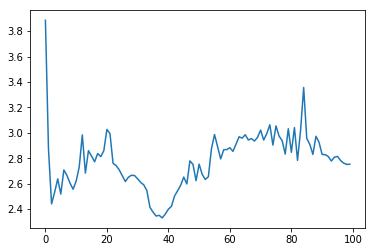

In [11]:
plt.plot(l2_osc)

In [12]:
print(g1g2_iter)
print(g2g1_iter)

[468, 119, 76, 63, 66, 96, 85, 81, 87, 77, 81, 96, 92, 95, 94, 98, 101, 110, 107, 101, 115, 133, 109, 118, 118, 112, 103, 108, 109, 111, 111, 108, 106, 103, 91, 85, 80, 80, 81, 81, 88, 89, 94, 98, 100, 105, 98, 113, 111, 100, 111, 106, 103, 106, 123, 131, 126, 126, 125, 125, 124, 122, 125, 133, 137, 134, 132, 133, 134, 134, 137, 136, 135, 140, 138, 136, 139, 139, 138, 143, 138, 135, 141, 143, 231, 145, 172, 137, 171, 159, 136, 133, 136, 137, 137, 140, 141, 138, 138, 139]
[136, 95, 59, 69, 77, 65, 76, 73, 70, 65, 66, 72, 96, 71, 83, 80, 75, 77, 79, 82, 94, 91, 84, 86, 85, 84, 83, 86, 89, 91, 91, 91, 91, 89, 79, 75, 72, 72, 70, 72, 73, 74, 77, 80, 82, 86, 81, 93, 92, 85, 92, 87, 85, 87, 98, 103, 100, 97, 100, 100, 100, 98, 100, 103, 102, 103, 100, 100, 98, 100, 104, 97, 101, 109, 94, 115, 102, 99, 92, 111, 91, 110, 87, 111, 131, 114, 99, 96, 103, 102, 94, 95, 92, 86, 92, 93, 89, 90, 91, 93]
